# Imports

In [42]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import re
from string import punctuation
from string import punctuation
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
!pip install tensorflow-gpu

# Dataset

Save the file in the same directory as train.csv before running the blocks below

https://www.kaggle.com/c/nfl-big-data-bowl-2020/download/rnAUsHGj9lT4lWIyUuEY%2Fversions%2FCEsJVtBEv0Z8nlYsmcDZ%2Ffiles%2Ftrain.csv

# Install Keras & Tensorflow if Needed

In [2]:
# !pip install keras
# !pip install tensorflow

# Data Preprocessing

In [43]:
train = pd.read_csv("train.csv")

#Fixing Stadium Type
def fix_stadiumtype(x):
    
    if re.search('retr',str(x).lower()):
        return 'indoor'
    
    elif re.search('roof',str(x).lower()):
        return 'indoor'

    elif re.search('out',str(x).lower()):
        return 'outdoor'
    
    elif re.search('close',str(x).lower()):
        return 'indoor'
    
    elif re.search('indoor',str(x).lower()):
        return 'indoor'
    
    elif re.search('open',str(x).lower()):
        return 'outdoor'
    
    elif re.search('dome',str(x).lower()):
        return 'indoor'
    
    elif re.search('bowl',str(x).lower()):
        return 'outdoor'
    
    elif re.search('field',str(x).lower()):
        return 'outdoor'
    
    elif re.search('ou.?door',str(x).lower()):
        return 'outdoor'
    
    else:
        return 'outdoor'
    
train['StadiumType'] = train['StadiumType'].apply(fix_stadiumtype)
    

# Player Height

def fix_height(x):
    a = str(x).split('-')
    return float(a[0]) *12 + float(a[1])

train['PlayerHeight'] = train['PlayerHeight'].apply(fix_height)

#Calculating the difference between Snap and Handoff Time
train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)

#Player Age Calculation
train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)

# Fix Turf

def fix_turf(x):
    
    if re.search('turf',str(x).lower()):
        return 'artificial'
    
    elif re.search('natural',str(x).lower()):
        return 'natural'
    
    elif re.search('artifi',str(x).lower()):
        return 'artificial'
    
    elif re.search('grass',str(x).lower()):
        return 'natural'
    
    elif re.search('ubu',str(x).lower()):
        return 'artificial'
    
    else:
        return 'natural'
    
train['Turf'] = train['Turf'].apply(fix_turf)

#Replace temperature by Median
train['Temperature'][train['Temperature'].isnull() == True] = 60.436442

#replace Humidity
train['Humidity'][train['Humidity'].isnull() == True] = 55.646062

#Fix WindSpeed
def fix_windspeed(x):
    a = re.findall(r'[\d]+',str(x))
    
    if len(a) == 2:
        return (float(a[0]) + float(a[1]))/2
    
    elif len(a) == 1:
        return float(a[0])
    
    elif len(a) == 0:
        return 5.476258188
    
    else:
        return x
    
train['WindSpeed'] = train['WindSpeed'].apply(fix_windspeed)

from string import punctuation

def fix_winddirection(x):
    
    if pd.isna(x) or x in["8","1","13"]:
        return "calm"
    
    x = str(x).lower()
    x= str(x).replace(" ","")
    x= str(x).replace("from","")
    x = ''.join([c for c in x if c not in punctuation])
    if re.search('south',x):
        x =  x.replace('south','s')
    
    if re.search('north',x):
        x =  x.replace('north','n')
    
    if re.search('west',x):
        x =  x.replace('west','w')

    if re.search('east',x):
        x =  x.replace('east','e')

    return x
  
def create_class_winddir(x):
    
    if x in ["calm"]:
        return "winddir_class_1"
    
    elif x in ["s","n"]:
        return "winddir_class_2"
    
    elif x in ["ssw","nnw","sse","nne"]:
        return "winddir_class_3"
    
    elif x in ["sw","nw","se","ne"]:
        return "winddir_class_4"
    
    elif x in ["ene","wnw","ese","wsw"]:
        return "winddir_class_5"
    
    elif x in ["e","w"]:
        return "winddir_class_6"
    
    else:
        return "winddir_class_1"
    
train['WindDirection']= train['WindDirection'].apply(fix_winddirection)
train['WindDirection'] = train['WindDirection'].apply(create_class_winddir)

#Fix Game Weather
    
def fix_gameweather(x):

    if pd.isna(x):
        return np.nan
    
    x = str(x).lower()
    x= str(x).replace(" ","")
    x = ''.join([c for c in x if c not in punctuation])

    if re.search('control',x) :
        return "control" 
    elif  re.search('indoor',x):
        return "control"
    
    elif re.search('rain',x) or re.search('shower',x):
        if re.findall(r"[\d]+%?",x):
            return re.findall(r"[\d]+%?",x)[0] + 'rain'
            
        elif re.search('part',x):
            return "partlyrain"
        else:
            return "rain"
    
    elif re.search('snow',x):
        return "snow" 
    
    elif re.search('cold',x):
        return "cold" 
    
    elif re.search('clear',x) or re.search('fair',x) or re.search('mph',x) :
        return "clear" 
    
    elif re.search('sun',x):
        if re.search('part',x):
            return "partlysun"
        else:
            return "sun"
    
    elif re.search('cloud',x) or re.search('overcast',x) or re.search('coudy',x) or re.search('hazy',x) or re.search("clouidy",x):
        if re.search('part',x):
            return "partlycloudy"
        else:
            return "cloudy"
    else:
        return x
    
import re
    

def weather_weights(x):
    
    if pd.isna(x):
        return 0
    try:
        if re.search("snow",x):
            return -3
    except:
        print(x)
        return 0
    
    
    if re.search("sun",x):
        if re.search("partly",x):
            return 0.5
        else:
            return 1
    elif re.search("cloud",x):
         if re.search("partly",x):
            return -0.25
         else:
            return -0.5
        
    elif re.search("clear",x):
        return 1.5

    elif re.search("cold",x):
        return -1
    
    elif re.search("rain",x):
        if re.findall(r"[\d]+",x):
            if len(re.findall(r"[\d]+",x)[0]) == 2:
                return int(re.findall(r"[\d]+",x)[0])/100 * (-2)
            else:
                return (int(re.findall(r"[\d]+",x)[0][:2]) + int(re.findall(r"[\d]+",x)[0][2:]))/200 * (-2)   
        else:
            return -2
    
    elif re.search("control",x):
        return 3
    else:
        return 0
    

    
train['GameWeather'] = train['GameWeather'].apply(fix_gameweather)
train['GameWeather'] = train['GameWeather'].apply(weather_weights)

#Fix Team Names
def fix_team_name(x):
    
    if x == 'BLT':
        return 'BAL'
    elif x == 'CLV':
        return 'CLE'
    elif x == 'ARZ':
        return 'ARI'
    elif x == 'HST':
        return 'HOU'
    else:
        return x

train['PossessionTeam'] = train['PossessionTeam'].apply(fix_team_name)
train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')

#checking if the player is the rusher
train['IsRusher'] = train['NflId'] == train['NflIdRusher']

#Fixing the Orientation of Player and Running Direction
def fix_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
train['Orientation'] = train.apply(lambda row: fix_orientation(row['Orientation'], row['PlayDirection']), axis=1)
train['Dir'] = train.apply(lambda row: fix_orientation(row['Dir'], row['PlayDirection']), axis=1)

#Yards Left to Finish Line
train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']
train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

train.drop(train.index[(train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])], inplace=True)

#calculating kinetic energy and momentum
train['momentum'] = train['PlayerWeight']*train['S']
# train['KineticEnergy'] = 0.5*train['PlayerWeight']*(train['S'])**2
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

#Calculating Game Clock
def gameclock():
    lis_gameclock = list()
    for time in train["GameClock"].unique():
        lis_gameclock.append(int(time.split(':')[0])*60 + int(time.split(':')[1]))
    dict_gameclock = {i:j for i,j in zip(train["GameClock"].unique(),lis_gameclock)}
    return dict_gameclock

train['GameClock'] = train["GameClock"].map(gameclock())
train["GameClock"] = (train['Quarter']-1)*15*60 - train['GameClock'] + 900 




# encode_formation = pd.get_dummies(train['OffenseFormation'])
# train = pd.concat([train,encode_formation], axis = 1)
# encode_Wdirection = pd.get_dummies(train['WindDirection'])
# train = pd.concat([train, encode_Wdirection], axis = 1)


C:\Users\piyus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\piyus\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\piyus\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Web Scraping and Data Augmentation

In [44]:
names = list()
scores = list()
url_lis = list()

def names_scores(url, names, scores): #gets names and scores of football players
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.content.decode('utf-8'))
    for p in soup.find_all('a'):
        try:
            if p.get('class')[0] == 'playerCard' or p.get('class')[0] == 'playerName':
                names.append(p.text)
        except:
            continue
    for s in soup.find_all('span'):
        try:
            if s.get('class')[0] == 'playerSeasonTotal':
                scores.append(s.text)
        except:
            continue
    return names,scores


def get_urls(url): #uses recursion to go through the next pages and get urls of all pages
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.content.decode('utf-8'))
    url_lis.append(url)
    for next_link in soup.find_all('li'):
        try:
            if (next_link.get('class'))[0] == 'next':
                new_url = 'https://fantasy.nfl.com/research/players' + next_link.find('a').get('href')
        except:
            continue
    return get_urls(new_url)

#using functions to get names and scores of the players
names_2017 = []
scores_2017 = []
try:
    get_urls('https://fantasy.nfl.com/research/scoringleaders?offset=1&position=O&sort=pts&statCategory=stats&statSeason=2017&statType=seasonStats&statWeek=13')
except:
    pass
for url in url_lis:
    names_scores(url, names_2017, scores_2017)
# print('2017 done')
#tuple of player name and score
NameScore_dict_2017 = dict([(n,s) for n,s in (zip([name.lower() for name in names_2017],[float(score) for score in scores_2017]))])
#PlayerScore column in the dataframe gives the score fore each player. A lot of NaN Values
train['PlayerScore'] = train['DisplayName'].str.lower().map(NameScore_dict_2017)

In [45]:
#including team rankings
url = 'https://www.teamrankings.com/nfl/rankings/teams/?date=2018-02-05'
wiki_url = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Football_League/National_Football_League_team_abbreviations'
response_wiki = requests.get(wiki_url)
soup_wiki = bs4.BeautifulSoup(response_wiki.content.decode('utf-8'))
response = requests.get(url)
soup = bs4.BeautifulSoup(response.content.decode('utf-8'))
team = []
for td in soup_wiki.find_all('td'):
    team.append(td.text)
    
name = []
for i in soup_wiki.find_all('td'):
    try:
        name.append(i.find('a').get('title'))
    except:
        continue


abb = []
for i in soup_wiki.find_all('td'):
    if len(i.text) <= 4:
        abb.append(i.text.replace('\n',''))
        
dict_abb_name = dict(zip(name, abb))

name_rank = []
for name in soup.find_all('td', class_='text-left nowrap'):
    name_rank.append(name.find('a').text)

a_dict= {name_rank[i-1]:i for i in range(1,33)}

df_temp_dict = pd.DataFrame()
df_temp_dict['names'] = a_dict.keys()
df_temp_dict['names'] = df_temp_dict['names'].map(dict_abb_name)
df_temp_dict['rank'] = a_dict.values()
rank_dict = df_temp_dict.set_index(['names']).to_dict()['rank']

# train['PossessionTeamRank'] = train["PossessionTeam"].map(rank_dict)
train['HomeTeamRank'] = train['HomeTeamAbbr'].map(rank_dict)
train['VisitorTeamRank'] = train['VisitorTeamAbbr'].map(rank_dict)
#train[['PossessionTeamRank', 'HomeTeamRank', 'VisitorTeamRank']]

In [46]:
play_rusher = train[train['NflId']==train['NflIdRusher']]
play_rusher_cordinates = play_rusher[['PlayId','X','Y']].rename(columns={'X':'X_rusher','Y':'Y_rusher'})

train = pd.merge(train, play_rusher_cordinates, how='left', on='PlayId',
       sort=False, suffixes=("x","y"),
       copy=True, indicator=False,
       validate=None)

train['dist_from_rusher']=np.sqrt((train['X_rusher']-train['X'])*2 + (train['Y_rusher']-train['Y'])*2)
train['opp_or_team'] = np.where(train['HomePossesion']^train['Team'],"opp_to_rusher","team_to_rusher")
play_team_dist_from_rusher = train.groupby(['PlayId','opp_or_team']).agg({'dist_from_rusher':'mean'}).reset_index()
play_dist_from_rusher_wide = play_team_dist_from_rusher.pivot(index='PlayId', columns='opp_or_team', values='dist_from_rusher').reset_index().rename(columns={'opp_to_rusher':'avg_rusher_dist_to_opp','team_to_rusher':'avg_rusher_dist_to_team'})
train = pd.merge(train, play_dist_from_rusher_wide, how='left', on='PlayId',
       sort=False, suffixes=("x","y"),
       copy=True, indicator=False,
       validate=None)
train.fillna(-999, inplace=True)

C:\Users\piyus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


# Visualizations

Formations

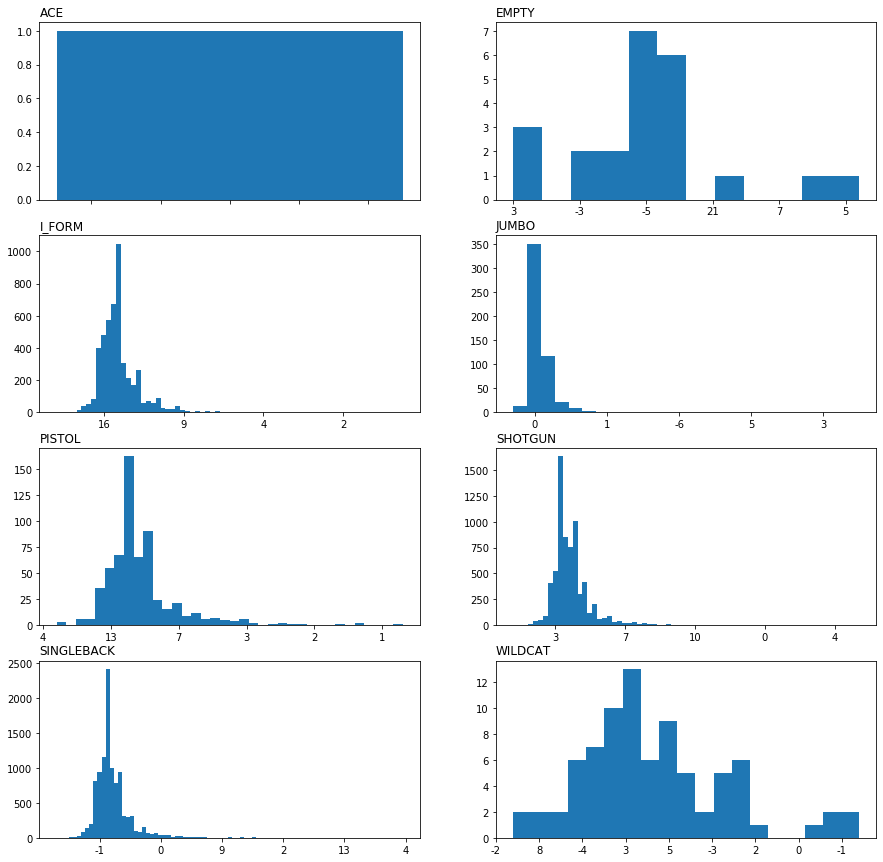

In [7]:
df = pd.read_csv('train.csv')
df = df[df['NflId'] == df['NflIdRusher']]
df_gr = df.groupby(['OffenseFormation']).mean()
formations = np.array(df_gr.index.tolist()).reshape(4,2)
figs, axs = plt.subplots(4,2)
figs.set_figwidth(15)
figs.set_figheight(15)



for i in range(4):
    for j in range(2):
        var_filter = df[df['OffenseFormation'] == formations[i][j]]['Yards']
        axs[i,j].hist(var_filter, bins = len(var_filter.unique()))
        axs[i,j].set_xticklabels(var_filter.unique())
        axs[i,j].set_title(formations[i][j], loc = 'left')


Yards Left

<BarContainer object of 99 artists>

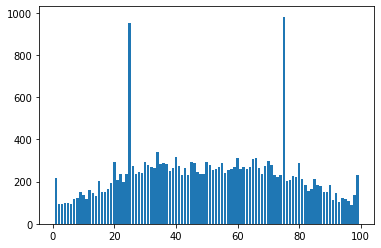

In [28]:

df_yards = train[train['NflId'] == train['NflIdRusher']][['YardsLeft','Yards']]

plt.bar(df_yards.sort_values(['YardsLeft']).groupby(['YardsLeft']).count().index,df_yards.sort_values(['YardsLeft']).groupby(['YardsLeft']).count()['Yards'].values)



Position

<BarContainer object of 9 artists>

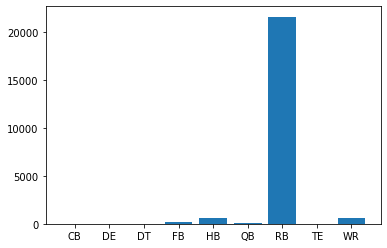

In [31]:
df_pos = df[df['NflId'] == df['NflIdRusher']][['Position','Yards']]
plt.bar(df_pos.groupby(['Position']).count().index, df_pos.groupby(['Position']).count().Yards)

# Light GBM 

In [52]:
#Categorical variables for label encoding/OneHot Encoding
a = ['HomeField','PlayDirection','HomePossesion','WindDirection',
     'Team','OffenseFormation','StadiumType','Turf']

for i in a:
    train[i] = train[i].astype('str')
    
le = preprocessing.LabelEncoder()
for i in a:
    train[i] = le.fit_transform(train[i])


Model_X = train[train['IsRusher']==True]
Model_Y = le.fit_transform(Model_X['Yards'])
Model_X.drop(['Yards', 'IsRusher','GameId', 'PlayId','NflId','DisplayName','HomeTeamAbbr','OffensePersonnel','Position',
              'VisitorTeamAbbr','Stadium','Location','JerseyNumber','Season','PlayerCollegeName','Week','YardLine',
              'PlayerBirthDate','TimeHandoff','TimeSnap','NflIdRusher', 'X_rusher', 'Y_rusher', 'dist_from_rusher','DefensePersonnel',
               'opp_or_team',"FieldPosition","PossessionTeam","FieldPosition"],axis = 1, inplace = True)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Model_X, Model_Y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)


C:\Users\piyus\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Grid Search for Hyper Parameter Tuning

This part of the code will take atleast 3-4 hours to run. The best parameters have been used to produce the model in the following block

In [53]:
# import lightgbm as lgb

# param_grid = {
#     'num_leaves': [15,31,63],
#     'min_data_in_leaf': [5,10,30, 50, 100],
#     'max_depth': [5, 10, 25],
#     'num_class': [199]
#     }

# lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass', num_boost_round=200, learning_rate=0.01, metric='multi_logloss')

# gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=5)
# lgb_model = gsearch.fit(X=x_train, y=y_train)

# print(lgb_model.best_params_, lgb_model.best_score_)

In [54]:
import lightgbm as lgb
d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_class'] = 199
params['num_leaves'] = 15
params['min_data'] = 100
params['max_depth'] = 5
clf = lgb.train(params, d_train, num_boost_round=200,
                feature_name=list(Model_X.columns),
                categorical_feature = a,verbose_eval = 10)
#,early_stopping_rounds = 10


C:\Users\piyus\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['HomeField', 'HomePossesion', 'OffenseFormation', 'PlayDirection', 'StadiumType', 'Team', 'Turf', 'WindDirection']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


# Performance Function

In [55]:
def squared_loss(y_train_y,y_pred):
    x = y_train_y - y_pred
    y = np.square(x)
    return (y.sum())/(y_pred.shape[0]*y_pred.shape[1])

# Prediction

In [56]:
y_pred=clf.predict(x_test)
results = np.cumsum(y_pred, axis=1)

In [57]:
n = y_test
o = np.zeros((n.size, 199))
o[np.arange(n.size),n] = 1
y_train_y = np.cumsum(o,axis =1)

In [58]:
squared_loss(y_train_y,results)

0.012523492882735748

# Feature Importance

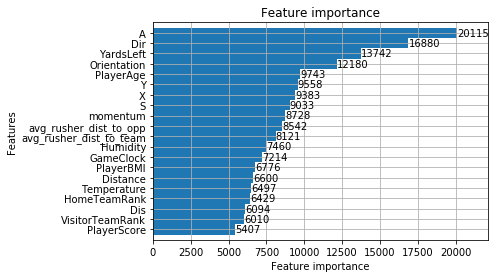

In [59]:
lgb.plot_importance(clf,height=1.0,max_num_features=20)

# Neural Net

In [60]:
NN_df = train

In [61]:
#OneHot Encoding the Categorical Variables
for i in a:
    encode_formation = pd.get_dummies(NN_df[i],prefix = i)
    NN_df = pd.concat([NN_df,encode_formation], axis = 1)
    NN_df.drop([i],axis = 1, inplace = True)
    
Model_X = NN_df[NN_df['IsRusher']==True]
Model_Y = le.fit_transform(Model_X['Yards'])
Model_X.drop(['Yards', 'IsRusher','GameId', 'PlayId','NflId','DisplayName','HomeTeamAbbr','OffensePersonnel','Position',
              'VisitorTeamAbbr','Stadium','Location','JerseyNumber','Season','PlayerCollegeName','Week','DefensePersonnel',
              'PlayerBirthDate','TimeHandoff','TimeSnap','NflIdRusher', 'X_rusher', 'Y_rusher', 'dist_from_rusher',
               'opp_or_team',"FieldPosition","PossessionTeam","FieldPosition"],axis = 1, inplace = True)
    
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Model_X, Model_Y, test_size = 0.25, random_state = 0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)


C:\Users\piyus\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
def crps(y_true, y_pred):
    return K.mean(K.square(y_true - K.cumsum(y_pred, axis=1)), axis=1)

In [63]:
def get_model():
    x = keras.layers.Input(shape=[x_train.shape[1]])
    fc1 = keras.layers.Dense(units = 400, input_shape=[x_train.shape[1]])(x)
    act1 = keras.layers.ReLU()(fc1)
    bn1 = keras.layers.BatchNormalization()(act1)
    dp1 = keras.layers.Dropout(0.3)(bn1)
    
    fc2 = keras.layers.Dense(units=700, input_shape=[x_train.shape[1]])(dp1)
    act2 = keras.layers.ReLU()(fc2)
    bn2 = keras.layers.BatchNormalization()(act2)
    dp2 = keras.layers.Dropout(0.4)(bn2)

    
    fc3 = keras.layers.Dense(units=450)(dp2)
    act3 = keras.layers.ReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.25)(bn3)

    
    fc4 = keras.layers.Dense(units=300)(dp3)
    act4 = keras.layers.ReLU()(fc4)
    bn4 = keras.layers.BatchNormalization()(act4)
    dp4 = keras.layers.Dropout(0.12)(bn4)

    
    output = keras.layers.Dense(units=199, activation='softmax')(dp3)
    model = keras.models.Model(inputs=[x], outputs=[output])
    return model


def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer='Adadelta', loss=crps)
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=64)
    return model

In [64]:
n = y_train
o = np.zeros((n.size, 199))
o[np.arange(n.size),n] = 1
y_train_x = np.cumsum(o,axis =1)

In [65]:
x_tr, x_vl, y_tr, y_vl = train_test_split(x_train, y_train_x, test_size=0.25, random_state=42)
model = train_model(x_tr, y_tr, x_vl, y_vl)

InternalError: cudaGetDevice() failed. Status: cudaGetErrorString symbol not found.

# Prediction

In [147]:
y_pred = model.predict(x_test)
results = np.cumsum(y_pred,axis=1)
squared_loss(y_train_y,results)

0.013446799860368086

# Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression


In [48]:
LR_model = LogisticRegression(solver = 'lbfgs',multi_class='multinomial')
LR_model.fit(x_train,y_train)


C:\Users\piyus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
y_pred = LR_model.predict(x_test)
n = y_pred
o = np.zeros((n.size, 199))
o[np.arange(n.size),n] = 1
y_train_pred = np.cumsum(o,axis =1)

In [50]:
squared_loss(y_train_y,y_train_pred)

0.017935240083982753

# Ensemble

In [51]:
#LGBM results
y_pred=clf.predict(x_test)
y_pred_lgbm = np.cumsum(y_pred, axis=1)

#NN results
y_pred = model.predict(x_test)
y_pred_nn = np.cumsum(y_pred,axis=1)

NameError: name 'model' is not defined

In [142]:
y_ensemble = (y_train_pred+y_pred_lgbm+y_pred_nn)/3
squared_loss(y_train_y,y_ensemble)

0.01344717167457061